# Import Packages

In [21]:
import pandas as pd
import os
import glob
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Import miscellaneous files and define functions

In [22]:
# Function for calculating euclidean distance
def EuclideanDistCald(bp1xVals, bp1yVals, bp2xVals, bp2yVals, currPixPerMM):
        series = (np.sqrt((bp1xVals - bp2xVals) ** 2 + (bp1yVals - bp2yVals) ** 2))  / currPixPerMM
        return series

# Import video info file containing pixels/mm for each video
video_info = pd.read_csv('video_info.csv')

# Import feat_dict file containing dictionary with general categories for large feature dataset
with open('feat_dict.json') as json_file:
    data = json.load(json_file)
data

{'adult_body_points': ['nose_x',
  'nose_y',
  'head_center_x',
  'head_center_y',
  'ear_left_x',
  'ear_left_y',
  'ear_right_x',
  'ear_right_y',
  'neck_x',
  'neck_y',
  'side_left_x',
  'side_left_y',
  'side_right_x',
  'side_right_y',
  'body_center_x',
  'body_center_y',
  'hip_left_x',
  'hip_left_y',
  'hip_right_x',
  'hip_right_y',
  'tailbase_x',
  'tailbase_y',
  'tail_tip_x',
  'tail_tip_y',
  'tail_center_x',
  'tail_center_y',
  'tail_upper_x',
  'tail_upper_y',
  'tail_lower_x',
  'tail_lower_y'],
 'adult_body_prob': ['nose_p',
  'head_center_p',
  'ear_left_p',
  'ear_right_p',
  'neck_p',
  'side_left_p',
  'side_right_p',
  'body_center_p',
  'hip_left_p',
  'hip_right_p',
  'tailbase_p',
  'tail_tip_p',
  'tail_center_p',
  'tail_upper_p',
  'tail_lower_p'],
 'infant_and_nest_points': ['Infant1_head_x',
  'Infant1_head_y',
  'Infant1_middle_head_x',
  'Infant1_middle_head_y',
  'Infant1_middle_tail_x',
  'Infant1_middle_tail_y',
  'Infant1_tail_x',
  'Infant1_tai

In [23]:
%%time
# Define feature directory
features_directory = 'targets_inserted'
file_location = os.path.join(features_directory, '*.csv')

# create list of filenames for every video to be processed
# this list is the input for the video processing function
filenames = glob.glob(file_location)
videoname = []
for f in filenames:
    # establish name for output file from the input filename
    x = os.path.split(f)
    x = f
    videoname.append(x)
videoname

Wall time: 1.02 ms


['targets_inserted\\Gal_42_mother_retreive_trial_1.csv',
 'targets_inserted\\Gal_58_father_retreive_trial_1.csv',
 'targets_inserted\\Gal_60_virginfemale_retreive_trial_1.csv',
 'targets_inserted\\Gal_71_mother_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_54_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_67_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_68_father_retreive_trial_1.csv']

In [24]:
%%time
# Read in the csv file for each feature dataframe
dfs = []
for x in videoname:
    filepath = x
    features = pd.read_csv(filepath)
    features['videoname'] = pd.Series([x] * (len(features)))
    dfs.append(features)
    print(len(dfs))

1
2
3
4
5
6
7
Wall time: 47.8 s


# Pull out start and end of huddling annotations

In [25]:
huddling_starts = {}
huddling_ends = {}
for i in range(len(dfs)):
    huddling_start = []
    huddling_end = []
    df = dfs[i]
    # Find the frame numbers in which annotation of huddling begins and the frame numbers in which the
    # annotation of huddling ends
    for j in range(len(df)):
        if j == 0:
            if df['huddling'][j] == 1:
                huddling_start.append(j)
            else:
                continue
        elif j == len(df) - 1:
            if df['huddling'][j] == 1:
                huddling_end.append(j)
            else:
                continue
        else:
            if df['huddling'][j] == 1 and df['huddling'][j - 1] == 0:
                huddling_start.append(j)
            if df['huddling'][j] == 1 and df['huddling'][j + 1] == 0:
                huddling_end.append(j)
    huddling_starts[videoname[i]] = huddling_start
    huddling_ends[videoname[i]] = huddling_end

# Adult specific features

In [26]:
# Make empty dictionaries for features where the calculations for each video will be added
video_head_areas = {}
video_body_areas = {}

video_head_circularities = {}
video_body_circularities = {}

video_head_contains = {}
video_body_contains = {}

video_adult_head_nest = {}
video_adult_body_nest = {}

video_adult_head_movement = {}
video_adult_body_movement = {}

video_head_center_xs = []
video_head_center_ys = []
video_body_center_xs = []
video_body_center_ys = []
for i in range(len(dfs)):
    
    video_info_col = video_info[video_info['Video'] == videoname[i][17:-4]]
    ppm = video_info_col['pixels/mm'][video_info_col.index[0]]
    print(ppm)
    
    # Make empty lists where the values for each feature for each frame will be added
    head_areas = []
    body_areas = []
    
    head_circularities = []
    body_circularities = []
    
    head_center_xs = []
    head_center_ys = []
    body_center_xs = []
    body_center_ys = []
    
    head_contains = []
    body_contains = []
    
    df = dfs[i][data['adult_body_points']]
    dfi = dfs[i][data['infant_and_nest_points']]
    nest_info = dfs[i][data['infant_and_nest_points']]
    
    # Make a dataframe of the in nest infants columns and calculate the averages for in nest values for each 
    # infant
    columns = ['In_Nest_Infant1_head', 'In_Nest_Infant1_middle_head', 'In_Nest_Infant1_middle_tail',
               'In_Nest_Infant1_tail', 'In_Nest_Infant2_head', 'In_Nest_Infant2_middle_head',
               'In_Nest_Infant2_middle_tail', 'In_Nest_Infant2_tail']
    infants_in_nest = dfs[i][columns]
    
    infant1_in_nest_avg = (infants_in_nest['In_Nest_Infant1_head'] + infants_in_nest['In_Nest_Infant1_middle_head'] 
                + infants_in_nest['In_Nest_Infant1_middle_tail'] + infants_in_nest['In_Nest_Infant1_tail']) / 4
    infant2_in_nest_avg = (infants_in_nest['In_Nest_Infant2_head'] + infants_in_nest['In_Nest_Infant2_middle_head'] 
                + infants_in_nest['In_Nest_Infant2_middle_tail'] + infants_in_nest['In_Nest_Infant2_tail']) / 4
    
    # Make a hull of the adult's body, where in each frame each point is checked to be above a specific threshold
    # before being added to the hull. Make a polygon for the head and another for the body
    # Calculate the area and circularity of both the head and body polygons
    for j in range(len(df)):
        head_points_list = []
        p1 = Point(df['head_center_x'][j], df['head_center_y'][j])
        if dfs[i]['head_center_p'][j] > 0.5:
            head_points_list.append(p1)
        p2 = Point(df['ear_right_x'][j], df['ear_right_y'][j])
        if dfs[i]['ear_right_p'][j] > 0.5:
            head_points_list.append(p2)
        p3 = Point(df['neck_x'][j], df['neck_y'][j])
        if dfs[i]['neck_p'][j] > 0.5:
            head_points_list.append(p3)
        p4 = Point(df['ear_left_x'][j], df['ear_left_y'][j])
        if dfs[i]['ear_left_x'][j] > 0.5:
            head_points_list.append(p4)
        if len(head_points_list) < 3:
            head_points_list = [p1, p2, p3, p4]
        head_polygon = Polygon(head_points_list)
        body_points_list = []
        p1 = Point(df['neck_x'][j], df['neck_y'][j])
        if dfs[i]['neck_p'][j] > 0.5:
            body_points_list.append(p1)
        p2 = Point(df['side_right_x'][j], df['side_right_y'][j])
        if dfs[i]['side_right_p'][j] > 0.5:
            body_points_list.append(p2)
        p3 = Point(df['hip_right_x'][j], df['hip_right_y'][j])
        if dfs[i]['hip_right_p'][j] > 0.5:
            body_points_list.append(p3)
        p4 = Point(df['tailbase_x'][j], df['tailbase_y'][j])
        if dfs[i]['tailbase_x'][j] > 0.5:
            body_points_list.append(p4)
        p5 = Point(df['hip_left_x'][j], df['hip_left_y'][j])
        if dfs[i]['hip_left_p'][j] > 0.5:
            body_points_list.append(p5)
        p6 = Point(df['side_left_x'][j], df['side_left_y'][j])
        if dfs[i]['side_left_p'][j] > 0.5:
            body_points_list.append(p6)
        if len(body_points_list) < 3:
            body_points_list = [p1, p2, p3, p4, p5, p6]
        body_polygon = Polygon(body_points_list)
        
        head_area = head_polygon.area
        body_area = body_polygon.area
        head_areas.append(head_area)
        body_areas.append(body_area)
        
        head_circularity = (4 * np.pi) * head_area / (head_polygon.length) ** 2
        head_circularities.append(head_circularity)
        body_circularity = (4 * np.pi) * body_area / (body_polygon.length) ** 2
        body_circularities.append(body_circularity)
        
        head_center_x = head_polygon.centroid.x
        head_center_xs.append(head_center_x)
        head_center_y = head_polygon.centroid.y
        head_center_ys.append(head_center_y)
        
        body_center_x = body_polygon.centroid.x
        body_center_xs.append(body_center_x)
        body_center_y = body_polygon.centroid.y
        body_center_ys.append(body_center_y)
        
        # Calculate the number of infant points that are contained within the head and body polygon of the adult
        p1 = Point(dfi['Infant1_head_x'][j], dfi['Infant1_head_y'][j])
        p2 = Point(dfi['Infant1_middle_head_x'][j], dfi['Infant1_middle_head_y'][j])
        p3 = Point(dfi['Infant1_middle_tail_x'][j], dfi['Infant1_middle_tail_y'][j])
        p4 = Point(dfi['Infant1_tail_x'][j], dfi['Infant1_tail_y'][j])
        p5 = Point(dfi['Infant2_head_x'][j], dfi['Infant2_head_y'][j])
        p6 = Point(dfi['Infant2_middle_head_x'][j], dfi['Infant2_middle_head_y'][j])
        p7 = Point(dfi['Infant2_middle_tail_x'][j], dfi['Infant2_middle_tail_y'][j])
        p8 = Point(dfi['Infant2_tail_x'][j], dfi['Infant2_tail_y'][j])
        
        head_contain = 0
        body_contain = 0
        for point in [p1, p2, p3, p4, p5, p6, p7, p8]:
            if head_polygon.contains(point):
                head_contain += 1
            if body_polygon.contains(point):
                body_contain += 1
        if infant1_in_nest_avg[j] > 0 and infant2_in_nest_avg[j] > 0:
            head_contain /= 2
            body_contain /= 2
        head_contains.append(head_contain)
        body_contains.append(body_contain)
    
    # Sum the contains feature over 300 frames, where the present frame is in the middle of the 300 frame window
    head_contains = pd.Series(head_contains).rolling(300, min_periods=1, center=True).sum()
    body_contains = pd.Series(body_contains).rolling(300, min_periods=1, center=True).sum()
    video_head_contains[videoname[i]] = head_contains
    video_body_contains[videoname[i]] = body_contains
    video_head_areas[videoname[i]] = pd.Series(head_areas) / (ppm ** 2)
    video_body_areas[videoname[i]] = pd.Series(body_areas) / (ppm ** 2)
    video_head_circularities[videoname[i]] = pd.Series(head_circularities)
    video_body_circularities[videoname[i]] = pd.Series(body_circularities)
    
    head_center_xs = pd.Series(np.array(head_center_xs)).values
    head_center_ys = pd.Series(np.array(head_center_ys)).values
    body_center_xs = pd.Series(np.array(body_center_xs)).values
    body_center_ys = pd.Series(np.array(body_center_ys)).values
    
    nest_xs = nest_info['nest_centroid_home_x'].values
    nest_ys = nest_info['nest_centroid_home_y'].values
    
    video_head_center_xs.append(head_center_xs)
    video_head_center_ys.append(head_center_ys)
    video_body_center_xs.append(body_center_xs)
    video_body_center_ys.append(body_center_ys)
    
    # Calculate the distance between the adult head and the nest and the adult body and the nest
    # summing the values over 90 frames, with the present frame in the middle of the 90 frame window
    #(np.sqrt((center_xs - nest_xs) ** 2 + (center_ys - nest_ys) ** 2))  / ppm
    adult_head_nest_dist = EuclideanDistCald(head_center_xs, head_center_ys, nest_xs, nest_ys, ppm)
    adult_head_nest_dist = pd.Series(adult_head_nest_dist)
    adult_head_nest_dist_summed = pd.Series(adult_head_nest_dist.rolling(90, min_periods=1, center=True).sum())
    video_adult_head_nest[videoname[i]] = adult_head_nest_dist_summed
    
    adult_body_nest_dist = EuclideanDistCald(body_center_xs, body_center_ys, nest_xs, nest_ys, ppm)
    adult_body_nest_dist = pd.Series(adult_body_nest_dist)
    adult_body_nest_dist_summed = pd.Series(adult_body_nest_dist.rolling(90, min_periods=1, center=True).sum())
    video_adult_body_nest[videoname[i]] = adult_body_nest_dist_summed
    
    # Calculate the movement of the adult points except for the tail and nose
    # Separate the head points and body points into separate calculations, the sum the values over 300 frames
    # with the present frame in the middle of the 300 frame window
    adult_movement = dfs[i][data['movement_adult']]
    adult_head_movement_summed = pd.Series(np.zeros(len(adult_movement)))
    adult_body_movement_summed = pd.Series(np.zeros(len(adult_movement)))
    count = 0
    for column in adult_movement.columns:
        if 'nose' in column or 'tail' in column or 'all' in column:
            continue
        if 'head' in column or 'ear' in column or 'neck' in column:
            adult_head_movement_summed = adult_head_movement_summed + adult_movement[column]
        else:
            adult_body_movement_summed = adult_body_movement_summed + adult_movement[column]
        count += 1
    adult_head_movement_summed = pd.Series(adult_head_movement_summed.rolling(300, min_periods=1, center=True).mean())
    adult_body_movement_summed = pd.Series(adult_body_movement_summed.rolling(300, min_periods=1, center=True).mean())
    video_adult_head_movement[videoname[i]] = adult_head_movement_summed
    video_adult_body_movement[videoname[i]] = adult_body_movement_summed
    

19.353030573725224
20.23563611202108
18.41176470588235
18.823897055233296
19.176470588235293
18.352941176470583
18.764705882352946


In [27]:
# Calculate the body lengths of the adult (the average of the hip to head center euclidean distances)
body_lengths = {}
for i in range(len(dfs)):
    body_length = (dfs[i]['head_center_to_hip_left'] + dfs[i]['head_center_to_hip_right']) / 2
    body_length = (pd.Series(body_length).rolling(500, min_periods=1, center=True).mean())
    body_length = abs(body_length.diff())
    body_lengths[videoname[i]] = body_length

NameError: name 'video_adult_movement' is not defined

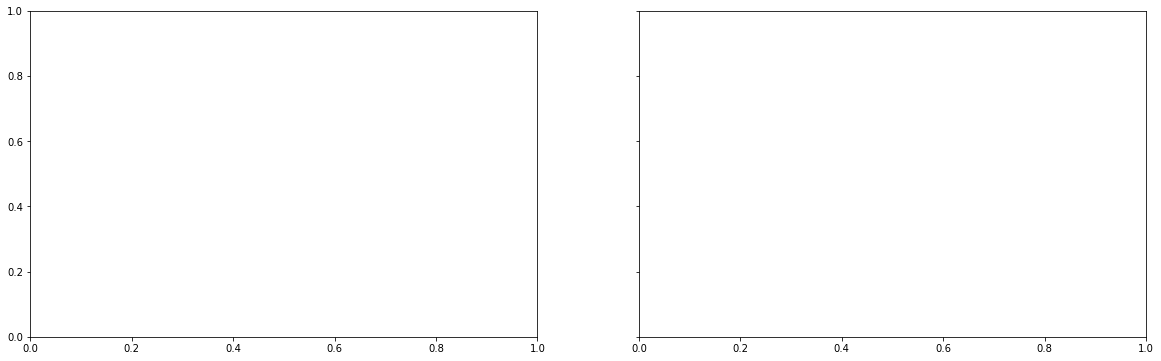

In [8]:
# Plot the curve of a feature from above agaisnt the labeled starts and ends of the huddling behavior
plt.subplots(1, 2, sharey=True, figsize=(20, 6))
count = 1
for i in range(len(huddling_starts[videoname[0]])):
    adult_nest = video_adult_movement[videoname[0]]
    starts = huddling_starts[videoname[0]]
    ends = huddling_ends[videoname[0]]
    fig = plt.subplot(1, 2, count)
    x_range = range(starts[i] - 100, ends[i])
    x_list = list(x_range)
    count += 1
    plt.plot(x_range, adult_nest[starts[i] - 100:ends[i]])
    plt.axvline(starts[i], color='orange')
    plt.axvline(ends[i], color='orange')

In [ ]:
# Plot the curve of a behavior from above over the entire video, with the green lines representing the starts of 
# labeled huddling and the red lines representing the ends of labeled huddling
plt.subplots(1, 1, sharey=True, figsize=(20, 10))
mov = video_contains[videoname[0]]
plt.subplot(1, 1, 1)
plt.plot(mov.index, mov)
for i in range(len(huddling_starts[videoname[0]])):
    starts = huddling_starts[videoname[0]]
    ends = huddling_ends[videoname[0]]
    plt.axvline(starts[i], color='green')
    plt.axvline(ends[i], color='red')
    plt.axhline(0, color='cyan')

In [28]:
# Make empty dictionaries for features where the calculations for each video will be added
videos_adult_in_nest = {}
videos_infants_bp_in_nest = {}
videos_summed_head_inf_dist = {}
videos_summed_body_inf_dist = {}
for i in range(len(dfs)):
    adult_in_nest = dfs[i]['In_Nest_Adult_body']
    videos_adult_in_nest[videoname[i]] = adult_in_nest
    
    # Add the in nest values for each point in each infant together
    columns = ['In_Nest_Infant1_head', 'In_Nest_Infant1_middle_head', 'In_Nest_Infant1_middle_tail',
               'In_Nest_Infant1_tail', 'In_Nest_Infant2_head', 'In_Nest_Infant2_middle_head',
               'In_Nest_Infant2_middle_tail', 'In_Nest_Infant2_tail']
    infants_in_nest = dfs[i][columns]
    infants_bp_in_nest = pd.Series(np.zeros(len(infants_in_nest)))
    for column in infants_in_nest.columns:
        infants_bp_in_nest = infants_bp_in_nest + infants_in_nest[column]
    videos_infants_bp_in_nest[videoname[i]] = infants_bp_in_nest
    
    head_center_xs = video_head_center_xs[i]
    head_center_ys = video_head_center_ys[i]
    head_center_xs = np.array(head_center_xs)
    head_center_ys = np.array(head_center_ys)
    
    body_center_xs = video_body_center_xs[i]
    body_center_ys = video_body_center_ys[i]
    body_center_xs = np.array(body_center_xs)
    body_center_ys = np.array(body_center_ys)
    
    infant1_center_xs = dfs[i]['Inf1_points_avg_x']
    infatn1_center_xs = dfs[i]['Inf1_points_avg_y']
    infant2_center_xs = dfs[i]['Inf2_points_avg_x']
    infant2_center_xs = dfs[i]['Inf2_points_avg_y']
    
    # Find the average of the infant in nest points for each infant
    infant1_in_nest_avg = (infants_in_nest['In_Nest_Infant1_head'] + infants_in_nest['In_Nest_Infant1_middle_head'] +
                           infants_in_nest['In_Nest_Infant1_middle_tail'] + infants_in_nest['In_Nest_Infant1_tail']) / 4
    infant2_in_nest_avg = (infants_in_nest['In_Nest_Infant2_head'] + infants_in_nest['In_Nest_Infant2_middle_head'] +
                           infants_in_nest['In_Nest_Infant2_middle_tail'] + infants_in_nest['In_Nest_Infant2_tail']) / 4
    infants_in_nest_avg = (infant1_in_nest_avg + infant2_in_nest_avg) / 2
    
    # Calculate the distance between the adult head and the infants and the adult body and the infants,
    # depending on which infants are in the nest
    head_infants_dist = []
    body_infants_dist = []
    for j in range(len(infants_in_nest)):
        if infant1_in_nest_avg[j] > 0 and infant2_in_nest_avg[j] == 0:
            head_infant_dist = EuclideanDistCald(head_center_xs[j], head_center_ys[j], infant1_center_xs[j], 
                                                  infant1_center_xs[j], ppm)
            head_infants_dist.append(head_infant_dist)
            
            body_infant_dist = EuclideanDistCald(body_center_xs[j], body_center_ys[j], infant1_center_xs[j], 
                                                  infant1_center_xs[j], ppm)
            body_infants_dist.append(body_infant_dist)
        elif infant1_in_nest_avg[j] == 0 and infant2_in_nest_avg[j] > 0:
            head_infant_dist = EuclideanDistCald(head_center_xs[j], head_center_ys[j], infant2_center_xs[j], 
                                                  infant2_center_xs[j], ppm)
            head_infants_dist.append(head_infant_dist)
            
            body_infant_dist = EuclideanDistCald(body_center_xs[j], body_center_ys[j], infant2_center_xs[j], 
                                                  infant2_center_xs[j], ppm)
            body_infants_dist.append(body_infant_dist)
        else:
            head_infant_dist1 = EuclideanDistCald(head_center_xs[j], head_center_ys[j], infant1_center_xs[j], 
                                                   infant1_center_xs[j], ppm)
            head_infant_dist2 = EuclideanDistCald(head_center_xs[j], head_center_ys[j], infant2_center_xs[j], 
                                                   infant2_center_xs[j], ppm)
            head_infants_dist.append((head_infant_dist1 + head_infant_dist2) / 2)
            
            body_infant_dist1 = EuclideanDistCald(body_center_xs[j], body_center_ys[j], infant1_center_xs[j], 
                                                   infant1_center_xs[j], ppm)
            body_infant_dist2 = EuclideanDistCald(body_center_xs[j], body_center_ys[j], infant2_center_xs[j], 
                                                   infant2_center_xs[j], ppm)
            body_infants_dist.append((body_infant_dist1 + body_infant_dist2) / 2)
            
    # Sum the distance values over 150 frames, with the present frame in the middle of the 150 frame window
    head_infants_dist = pd.Series(head_infants_dist)
    head_infants_dist = head_infants_dist.rolling(150, min_periods=1, center=True).mean()
    videos_summed_head_inf_dist[videoname[i]] = head_infants_dist
    
    body_infants_dist = pd.Series(body_infants_dist)
    body_infants_dist = body_infants_dist.rolling(150, min_periods=1, center=True).mean()
    videos_summed_body_inf_dist[videoname[i]] = body_infants_dist
    
videos_infants_bp_in_nest

{'targets_inserted\\Gal_42_mother_retreive_trial_1.csv': 0        0.0
 1        0.0
 2        0.0
 3        0.0
 4        0.0
         ... 
 11684    8.0
 11685    8.0
 11686    8.0
 11687    8.0
 11688    8.0
 Length: 11689, dtype: float64,
 'targets_inserted\\Gal_58_father_retreive_trial_1.csv': 0        0.0
 1        0.0
 2        0.0
 3        0.0
 4        0.0
         ... 
 11969    4.0
 11970    4.0
 11971    4.0
 11972    4.0
 11973    4.0
 Length: 11974, dtype: float64,
 'targets_inserted\\Gal_60_virginfemale_retreive_trial_1.csv': 0        0.0
 1        0.0
 2        0.0
 3        0.0
 4        0.0
         ... 
 28637    8.0
 28638    8.0
 28639    8.0
 28640    8.0
 28641    8.0
 Length: 28642, dtype: float64,
 'targets_inserted\\Gal_71_mother_retreive_trial_1.csv': 0        0.0
 1        0.0
 2        0.0
 3        0.0
 4        0.0
         ... 
 12345    8.0
 12346    8.0
 12347    8.0
 12348    8.0
 12349    8.0
 Length: 12350, dtype: float64,
 'targets_inserted\\Ucn3_5

In [ ]:
# Plot the curve of the adult nest distances against the labeled starts and ends of the huddling behavior
plt.subplots(1, 2, sharey=True, figsize=(20, 10))
count = 1
for i in range(len(huddling_starts[videoname[0]])):
    in_nest = videos_summed_adult_inf_dist[videoname[0]]
    starts = huddling_starts[videoname[0]]
    ends = huddling_ends[videoname[0]]
    fig = plt.subplot(1, 2, count)
    x_range = range(starts[i] - 500, ends[i])
    x_list = list(x_range)
    count += 1
    plt.plot(x_range, in_nest[starts[i] - 500:ends[i]])
    plt.axvline(starts[i], color='orange')
    plt.axvline(ends[i], color='orange')

In [ ]:
# Plot the curve of the adult nest distance values over the entire video, with the green lines representing the 
# starts of the huddling behavior and the red lines representing the ends of the huddling behavior
plt.figure(figsize=(20, 10))
in_nest = videos_summed_adult_inf_dist[videoname[0]]
plt.plot(in_nest.index, in_nest)
for i in range(len(huddling_starts[videoname[0]])):
    starts = huddling_starts[videoname[0]]
    ends = huddling_ends[videoname[0]]
    plt.axvline(starts[i], color='green')
    plt.axvline(ends[i], color='red')
    plt.axhline(9, color='cyan')

In [29]:
# Get the summed values of the adult points as well as the number of infant points for each frame whose probability
# is below 0.1
prob_sums = {}
low_prob_detections_infants = {}
for i in range(len(dfs)):
    probabilities = dfs[i]['sum_probabilities_adult']
    prob_sums[videoname[i]] = probabilities
    low_probs_infants = dfs[i]['Low_prob_detections_infants_0.1']
    low_prob_detections_infants[videoname[i]] = low_probs_infants

# ML model for huddling

In [30]:
# Make lists for train and test datasets where each extracted feature dataframe goes in either the train
# or test list below, as well as a list for the videoname of the dataframes in the test set
test_videoname = []
feats_dfs_train = []
feats_dfs_test = []
for i in range(len(videoname)):
    
    # Concatenate all the feature data along with retrieval annotations into a dataframe and label columns
    features_df = pd.DataFrame()
    huddling = dfs[i]['huddling']
    features_df = pd.concat([video_head_areas[videoname[i]], 
                             video_body_areas[videoname[i]], 
                             video_head_circularities[videoname[i]], 
                             video_body_circularities[videoname[i]], 
                             video_head_contains[videoname[i]], 
                             video_body_contains[videoname[i]],
                             video_adult_head_nest[videoname[i]], video_adult_body_nest[videoname[i]], 
                             video_adult_head_movement[videoname[i]], 
                             video_adult_body_movement[videoname[i]], 
                             body_lengths[videoname[i]],
                             videos_summed_head_inf_dist[videoname[i]], 
                             videos_summed_body_inf_dist[videoname[i]], 
                             prob_sums[videoname[i]], low_prob_detections_infants[videoname[i]], 
                             huddling], axis=1)
    
    features_df.columns = ['head_area', 
                           'body_area', 'head_circularity', 
                           'body_circularity',
                           'inf_points_in_head', 
                           'inf_points_in_body', 'head_nest_dist', 'body_nest_dist',
                           'head_mov', 
                           'body_mov', 'adult_bod_len', 'head_inf_dist', 'body_inf_dist', 
                           'probability_sums', 'infant_low_prob_detections', 'huddling']
    
    # Choose which videos go in the train and test set
    features_df = features_df.fillna(0)
    if i == 3 or i == 6:
        feats_dfs_test.append(features_df)
        test_videoname.append(videoname[i])
    else:
        feats_dfs_train.append(features_df)
        

In [33]:
# Concatenate the dataframes in the train and test set
feats_df_train = (pd.concat(feats_dfs_train).reset_index()).drop(['index'], axis=1)
#feats_df_test = (pd.concat(feats_dfs_test).reset_index()).drop(['index'], axis=1)

In [1]:
# Plot a correlation matrix for the features and annotations
plt.figure(figsize=(18,15))
correlation = feats_df_train.corr()
correlation = (correlation)
sns.heatmap(correlation, cmap='BrBG',
            mask=np.triu(np.ones_like(correlation, dtype=bool)), annot=True)

NameError: name 'plt' is not defined

In [35]:
# Separate the concatenate train dataframes into data and target dataframes
target_train = feats_df_train['huddling']
data_train = feats_df_train.drop(['huddling'], axis=1)

target_tests = []
data_tests = []
# For the test dataframes, keep the target and data information separate for each video
for i in range(len(feats_dfs_test)):
    target_test = feats_dfs_test[i]['huddling']
    data_test = feats_dfs_test[i].drop(['huddling'], axis=1)
    target_tests.append(target_test)
    data_tests.append(data_test)
#data_train, data_test, target_train, target_test = train_test_split(
#     data, target, test_size=0.2, random_state=42)

In [36]:
# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators=200, max_features='sqrt', n_jobs=-1,
                                     criterion='entropy', min_samples_leaf=10, bootstrap=True,
                                     verbose=1)

In [37]:
# Fir the rfc to the training data
rfc.fit(data_train, target_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   13.1s finished


RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=10, n_estimators=200, n_jobs=-1,
                       verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.8s finished


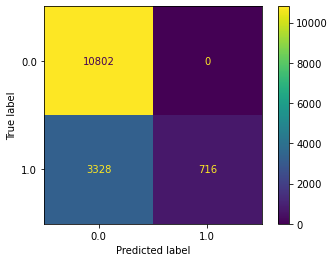

In [38]:
# Plot a confusion matrix for the trained rfc tested on the test set
from sklearn.metrics import plot_confusion_matrix

_ = plot_confusion_matrix(rfc, data_test, target_test)

In [39]:
# For each video in the test set, test the model on the test data to make predictions and append these to a 
# list containing the predictions for each video
from sklearn.metrics import balanced_accuracy_score
video_predictions = []
for i in range(len(target_tests)):
    predictions = rfc.predict(data_tests[i])
    video_predictions.append(pd.Series(predictions))

# Calculate the balanced accuracy of predictions against the labeled huddling behaviors    
#balanced_accuracy_test = balanced_accuracy_score(target_test, predictions)
#balanced_accuracy_all = balanced_accuracy_score(target_full, full_predictions)
#print(f"Balanced accuracy test: {balanced_accuracy_test:.3f}")
#print(f"Balanced accuracy full: {balanced_accuracy_all:.3f}")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


In [40]:
# Save the labeled huddling and predicted huddling dataframes for each video as csv files to make videos of
for i in range(len(target_tests)):
    target_tests[i].to_csv(r'make_annotated_video_huddling\\08_Manually_annotated_behaviors\\' + 
                           test_videoname[i][17:-4] + '_annotations.csv')
    video_predictions[i].to_csv(r'make_annotated_video_huddling\\08_Machine_learning_predictions\\' +
                           test_videoname[i][17:-4] + 'predictions.csv')

In [46]:
# Calculate the precision and recall of the test predictions against the labeled behavior
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('precision (tp / (tp + fp)): ', precision_score(target_test, predictions) * 100, '%')
print('recall (tp / (tp + fn)): ', recall_score(target_test, predictions) * 100, '%')

precision (tp / (tp + fp)):  72.59803921568627 %
recall (tp / (tp + fn)):  29.673412141855337 %


ValueError: x and y must have same first dimension, but have shapes (1991,) and (0,)

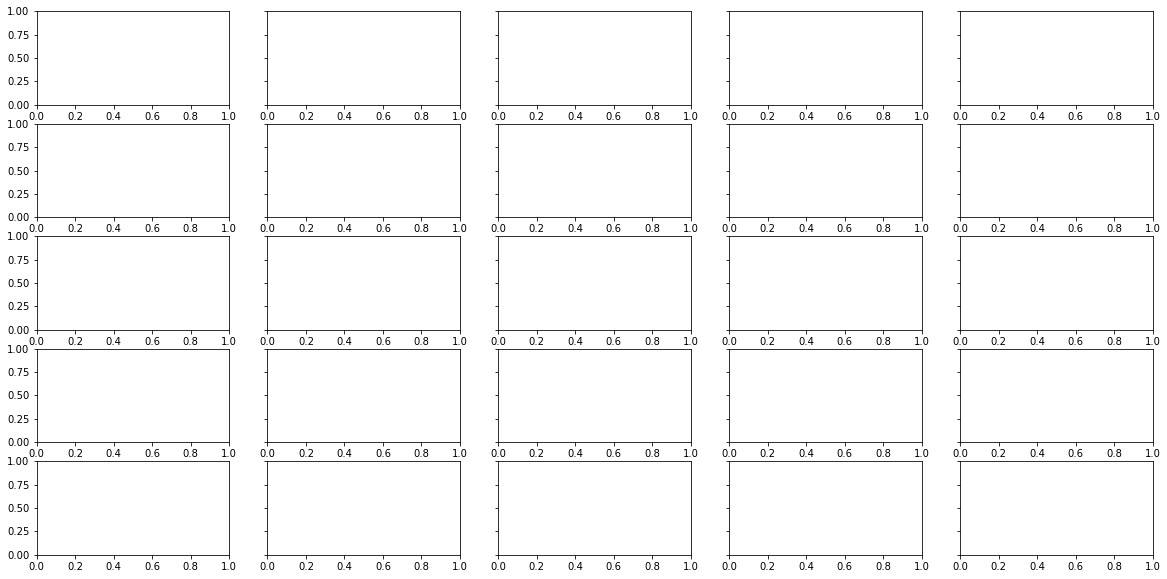

In [120]:
# Plot the predicted huddling behaviors against the labeled huddling behavior
plt.subplots(5, 5, sharey=True, figsize=(20,10))
count = 1
for i in range(len(huddling_starts[videoname[2]])):
    plt.subplot(5, 5, count)
    huddling_s = huddling_starts[videoname[2]]
    huddling_e = huddling_ends[videoname[2]]
    x_range = range(huddling_s[i] - 100, huddling_e[i])
    x_list = list(x_range)
    huddling_range = (range(huddling_s[i], huddling_e[i]))
    huddling_list = list(huddling_range)
    plt.plot(x_list, predictions[huddling_s[i] - 100: huddling_e[i]])
    plt.axvline(huddling_s[i], label='Start of Huddling', color='orange')
    plt.axvline(huddling_e[i], label='End of Huddling', color='orange')
    #plt.fill_between(approach_list, predictions[approach_s[i]: approach_e[i] + 1], 1, color='red')
    count += 1